In [2]:
import qpms
from qpms import *
import numpy as np
from numpy import newaxis as ň
import math

nm = 1e-9
μm = 1e-6
from scipy.constants import c, hbar, e as eV, pi

In [169]:
# We don't really need this particular function anymore, but...
def scuffTMatrixConvert_EM_01(EM):
    #print(EM)
    if (EM == b'E'):
        return 0
    elif (EM == b'M'):
        return 1
    else:
        return None

def loadScuffTMatrices(fileName):
    table = np.genfromtxt(fileName, 
                  converters={1: scuffTMatrixConvert_EM_01, 4: scuffTMatrixConvert_EM_01},
                  dtype=[('freq', '<f8'), ('outc_type', '<i8'), ('outc_l', '<i8'), ('outc_m', '<i8'), 
                         ('inc_type', '<i8'), ('inc_l', '<i8'), ('inc_m', '<i8'), ('Treal', '<f8'), ('Timag', '<f8')]
                          )
    lMax=np.max(table['outc_l'])
    my,ny = get_mn_y(lMax)
    nelem = len(ny)
    TMatrix_sz = nelem**2 * 4 # number of rows for each frequency: nelem * nelem spherical incides, 2 * 2 E/M types
    freqs_weirdunits = table['freq'][::TMatrix_sz].copy()
    freqs = freqs_weirdunits * c / μm
    # The iteration in the TMatrix file goes in this order (the last one iterates fastest, i.e. in the innermost loop):
    # freq outc_l outc_m outc_type inc_l inc_m inc_type
    # The l,m mapping is the same as is given by my get_mn_y function, so no need to touch that
    TMatrices_tmp_real = table['Treal'].reshape(len(freqs), nelem, 2, nelem, 2)
    TMatrices_tmp_imag = table['Timag'].reshape(len(freqs), nelem, 2, nelem, 2)
    # There are two přoblems with the previous matrices. First, we want to have the
    # type indices first, so we want a shape (len(freqs), 2, nelem, 2, nelem) as in the older code.
    # Second, M-waves come first, so they have now 0-valued index, and E-waves have 1-valued index,
    # which we want to be inverted.
    TMatrices = np.empty((len(freqs),2,nelem,2,nelem),dtype=complex)
    for inc_type in [0,1]:
        for outc_type in [0,1]:
            TMatrices[:,1-outc_type,:,1-inc_type,:] = TMatrices_tmp_real[:,:,outc_type,:,inc_type]+1j*TMatrices_tmp_imag[:,:,outc_type,:,inc_type]
    # IMPORTANT: now we are going from Reid's/Kristensson's/Jackson's/whoseever convention to Taylor's convention
    TMatrices[:,:,:,:,:] = TMatrices[:,:,:,:,:] * np.sqrt(ny*(ny+1))[ň,ň,ň,ň,:] / np.sqrt(ny*(ny+1))[ň,ň,:,ň,ň]
    return (TMatrices, freqs, freqs_weirdunits, lMax)

In [170]:
# In dipole-quadrupole (inc. E,M) simulations, single T-matrix takes 4 kB = 2**12 B,
# so the memory needed for the whole interaction matrix is 4 kB * (xN * yN)**2
xN = 20
yN = 20
xd = 400*nm # x spacing
yd = 400*nm # y spacing
epsilon_b = 2.3104 # this is constant, as in the FDTD simulations in the paper
inc_angle = 0.0 # Angle of incident field. The k-vector lies in the xz plane, this is the angle between k and z axis
k_dir = np.array([math.sin(inc_angle),0.,math.cos(inc_angle)])
E_0 = np.array([0.,1.,0.]) # electric field
fileName="/u/46/necadam1/unix/tmatrix-experiments/Cylinder/lasingPaper/Cylinder.TMatrix"

TMatrices, freqs, freqs_weirdunits, lMax = loadScuffTMatrices(fileName)



In [171]:
freqIndex = 41
TMatrix = TMatrices[freqIndex] 
omega = freqs[freqIndex]
k_out = omega * math.sqrt(epsilon_b) / c # wave number
k_cart = k_dir * k_out # wave vector of the incident plane wave
nmax = 2
my, ny = get_mn_y(nmax)
nelem = len(my)
TMatrix = TMatrix[:,0:nelem,:,0:nelem] # Fuck octupoles, if applicable
print(TMatrix.shape, omega, omega/eV*hbar, k_out, 2*pi/k_out)

N = yN*xN

J_scat=3
J_ext=1
#x, y = np.meshgrid(np.arange(xN)*xd,np.arange(yN)*yd)
#x = x.flatten()
#y = y.flatten()
#z = 0*x
#cart_lattice=np.stack((x,y,z), axis=-1)
xind, yind = np.meshgrid(np.arange(xN),np.arange(yN), indexing='xy')
xind = xind.flatten()
yind = yind.flatten()
xyind = np.stack((xind, yind, np.zeros((xind.shape),dtype=int)),axis=-1)
cart_lattice=xyind * np.array([xd, yd, 0])
x=cart_lattice[:,0]
y=cart_lattice[:,1]
xyind = xyind[:,0:2]

my, ny = get_mn_y(nmax)
nelem = len(my)

# Lattice speedup
Agrid = np.zeros((nelem, 2*xN, 2*yN, nelem),dtype=np.complex_)
Bgrid = np.zeros((nelem, 2*xN, 2*yN, nelem),dtype=np.complex_)
print(Agrid.shape)
import sys
sys.stdout.flush()
for yl in range(nelem): # source
    for xij in range(2*xN):
        for yij in range(2*yN):
            for yj in range(nelem): #dest
              if((yi != yN) or (xi != xN)):
                d_l2j = cart2sph(np.array([(xij-xN)*xd, (yij-yN)*yd, 0]))
                Agrid[yj, xij, yij, yl] = Ã(my[yj],ny[yj],my[yl],ny[yl],kdlj=d_l2j[0]*k_out,θlj=d_l2j[1],φlj=d_l2j[2],r_ge_d=False,J=J_scat)
                Bgrid[yj, xij, yij, yl] = B̃(my[yj],ny[yj],my[yl],ny[yl],kdlj=d_l2j[0]*k_out,θlj=d_l2j[1],φlj=d_l2j[2],r_ge_d=False,J=J_scat)
        
# Translation coefficient matrix T
transmat = np.zeros((xN* yN, 2, nelem, xN* yN, 2, nelem),dtype=np.complex_)
print(N*N*nelem*nelem, "iterations in creating da translatino matrix; gonna take about",
      N*N*nelem*nelem*3e-4,"s(?)")
sys.stdout.flush()
for l in range(N):
    xil, yil = xyind[l]
    for j in range(N):
        xij, yij = xyind[j]
        if (l!=j):
                    transmat[j,0,:,l,0,:] = Agrid[:, xij - xil + xN, yij - yil + yN, :]
                    transmat[j,0,:,l,1,:] = Bgrid[:, xij - xil + xN, yij - yil + yN, :]
                    transmat[j,1,:,l,0,:] = Bgrid[:, xij - xil + xN, yij - yil + yN, :]
                    transmat[j,1,:,l,1,:] = Agrid[:, xij - xil + xN, yij - yil + yN, :]


transmat.shape = (xN*yN,2,nelem,xN*yN,2,nelem)
print("so how much did it take?")
sys.stdout.flush()



print("Setting initial field")
sys.stdout.flush()
# The initial field (here plane wave) decomposition coefficients p_0, q_0 with respect
# to each particle
pq_0 = np.zeros((N,2,nelem), dtype=np.complex_)
p_y0, q_y0 = plane_pq_y(nmax, k_cart, E_0)

pq_0[:,0,:] = np.exp(1j*np.sum(k_cart[ň,:]*cart_lattice,axis=-1))[:, ň] * p_y0[ň, :]
pq_0[:,1,:] = np.exp(1j*np.sum(k_cart[ň,:]*cart_lattice,axis=-1))[:, ň] * q_y0[ň, :]

print("Initializing the matrix problem")
sys.stdout.flush()
# Now we solve a linear problem (1 - M T) A = M P_0
MT = np.empty((N,2,nelem,N,2,nelem),dtype=np.complex_)
MP_0 = np.empty((N,2,nelem),dtype=np.complex_)
for j in range(N): # I wonder how this can be done without this loop...
    MT[j] = np.tensordot(TMatrix,transmat[j],axes=([-2,-1],[0,1]))
    MP_0[j] = np.tensordot(TMatrix,pq_0[j],axes=([-2,-1],[-2,-1]))
leftmatrix = np.reshape(np.identity(N*2*nelem),(N,2,nelem,N,2,nelem)) - MT


print("solving")
sys.stdout.flush()
ab = np.linalg.tensorsolve(leftmatrix, MP_0)
print("Done.")
#np.angle(ab)

(2, 8, 2, 8) 3.22267898576e+15 2.12120582411 16339544.0 3.84538595886e-07
(8, 40, 40, 8)
10240000 iterations in creating da translatino matrix; gonna take about 3071.9999999999995 s(?)
so how much did it take?
Setting initial field
Initializing the matrix problem
solving
Done.


(-1, 20)

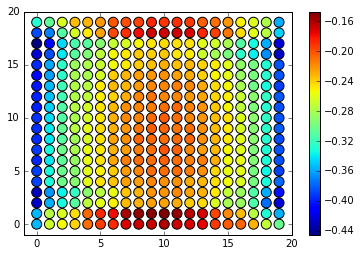

In [172]:
%matplotlib inline
from matplotlib import pyplot as plt
#xf.shape
#f, ax = plt.subplots()
#C = np.angle((ab[:,0,0]+ab[:,0,2]
#     ))
C = np.real(ab[:,0,0])#+ab[:,0,7])
C.shape=x.shape
plt.scatter(x/xd,y/xd,s=100,c=C,cmap='jet'
             )
plt.colorbar()
plt.xlim([-1,xN])
plt.ylim([-1,yN])

(-1, 20)

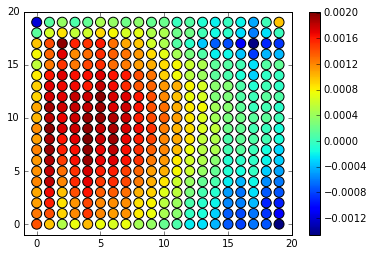

In [196]:

C = np.real(ab[:,0,3]-ab[:,0,7])
C.shape=x.shape
plt.scatter(x/xd,y/xd,s=100,c=C,cmap='jet'
             )
plt.colorbar()
plt.xlim([-1,xN])
plt.ylim([-1,yN])
#C

In [44]:
nelem**2*4

900

In [112]:
print(transmat[:,0,5,:,0,7])

[[  0.00000000e+00 +0.00000000e+00j   2.95472685e-02 +7.16091421e-02j
    1.03807811e-02 +1.50044272e-02j ...,   2.98311994e-05 -1.06174593e-04j
   -1.04401351e-04 +7.21156778e-06j   2.71737223e-05 +9.54956914e-05j]
 [  2.95472685e-02 +7.16091421e-02j   0.00000000e+00 +0.00000000e+00j
    2.95472685e-02 +7.16091421e-02j ...,   8.40316432e-05 +8.02348901e-05j
    2.98311994e-05 -1.06174593e-04j  -1.04401351e-04 +7.21156778e-06j]
 [  1.03807811e-02 +1.50044272e-02j   2.95472685e-02 +7.16091421e-02j
    0.00000000e+00 +0.00000000e+00j ...,  -1.20712587e-04 +1.98393645e-05j
    8.40316432e-05 +8.02348901e-05j   2.98311994e-05 -1.06174593e-04j]
 ..., 
 [  2.98311994e-05 -1.06174593e-04j   8.40316432e-05 +8.02348901e-05j
   -1.20712587e-04 +1.98393645e-05j ...,   0.00000000e+00 +0.00000000e+00j
    2.95472685e-02 +7.16091421e-02j   1.03807811e-02 +1.50044272e-02j]
 [ -1.04401351e-04 +7.21156778e-06j   2.98311994e-05 -1.06174593e-04j
    8.40316432e-05 +8.02348901e-05j ...,   2.95472685e-02 +

In [178]:
Mv,Nv=vswf_yr1(np.array([0.68,pi/2,pi/4]),2,3)

In [186]:
np.linalg.norm(Nv[3]-Nv[7], axis=-1)

70.585419210271709

In [165]:
4e-7/(2*pi*c/omega)

0.68434715670197899